In [10]:
import torch
import torch.hub
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

from FRM import AutoEncoder

In [3]:
model = torch.hub.load("facebookresearch/pytorchvideo","i3d_r50",pretrained=True)

Using cache found in /home/lasige/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [4]:
print(model.blocks[-1])
head = model.blocks[-1]

ResNetBasicHead(
  (pool): AvgPool3d(kernel_size=(4, 7, 7), stride=(1, 1, 1), padding=(0, 0, 0))
  (dropout): Dropout(p=0.5, inplace=False)
  (proj): Linear(in_features=2048, out_features=400, bias=True)
  (output_pool): AdaptiveAvgPool3d(output_size=1)
)


In [5]:
head.proj = nn.Identity()

In [7]:
print(model)

Net(
  (blocks): ModuleList(
    (0): ResNetBasicStem(
      (conv): Conv3d(3, 64, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
      (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
    (1): ResStage(
      (res_blocks): ModuleList(
        (0): ResBlock(
          (branch1_conv): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (branch1_norm): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (branch2): BottleneckBlock(
            (conv_a): Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
            (norm_a): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act_a): ReLU()
            (conv_b): Conv3d(64, 64, kernel_size=(1,

In [ ]:
frm_model = AutoEncoder()
optimizer = optim.AdamW(frm_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Testing if the model works correctly!
It looks like it!

In [87]:
def get_pred(vector):
    probabilities = F.softmax(vector, dim=0)

    predicted_class_index = torch.argmax(probabilities).item()
    csv_file_path = 'kinetics_400_labels.csv'

    df = pd.read_csv(csv_file_path)
    df = df.drop(columns=['id'])

    print(df.loc[predicted_class_index]['name'])
    

def load_video_frames(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in range(num_frames):
        frame_idx = int(i * (frame_count / num_frames))  # Sample evenly
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(frame)

    cap.release()
    return frames  # List of (H, W, C) numpy arrays

def preprocess_frames_2(frames):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the frames
        transforms.CenterCrop(224),     # Crop the frames to 112x112
        transforms.ToTensor(),          # Convert frames to tensor (values scaled to [0, 1])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
        transforms.ConvertImageDtype(torch.float32)  # Convert to float32
    ])

    processed_frames = []
    for frame in frames:
        pil_frame = Image.fromarray(frame)
        
        # Apply the transformation (which includes scaling to [0, 1], normalizing, and converting to float32)
        processed_frame = transform(pil_frame)
        
        # Clip values to [0, 1] after normalization (if necessary)
        processed_frame = torch.clamp(processed_frame, 0, 1)

        processed_frames.append(processed_frame)

    # Stack frames → Shape: (T, C, H, W) → (16, 3, 112, 112)
    video_tensor = torch.stack(processed_frames)

    # Rearrange dimensions to (B, C, T, H, W) → (1, 3, 16, 112, 112)
    return video_tensor.permute(1, 0, 2, 3).unsqueeze(0)

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

video_path = "kinetics400_5per/train/shaving head/FRr2SPY7Ouw.mp4"
frames = load_video_frames(video_path)
if len(frames) < 16:
    print("Warning: Not enough frames. Consider padding or skipping the video.")
inputs = preprocess_frames_2(frames).to(device) 
print(f'After: {inputs.shape}')

After: torch.Size([1, 3, 16, 224, 224])


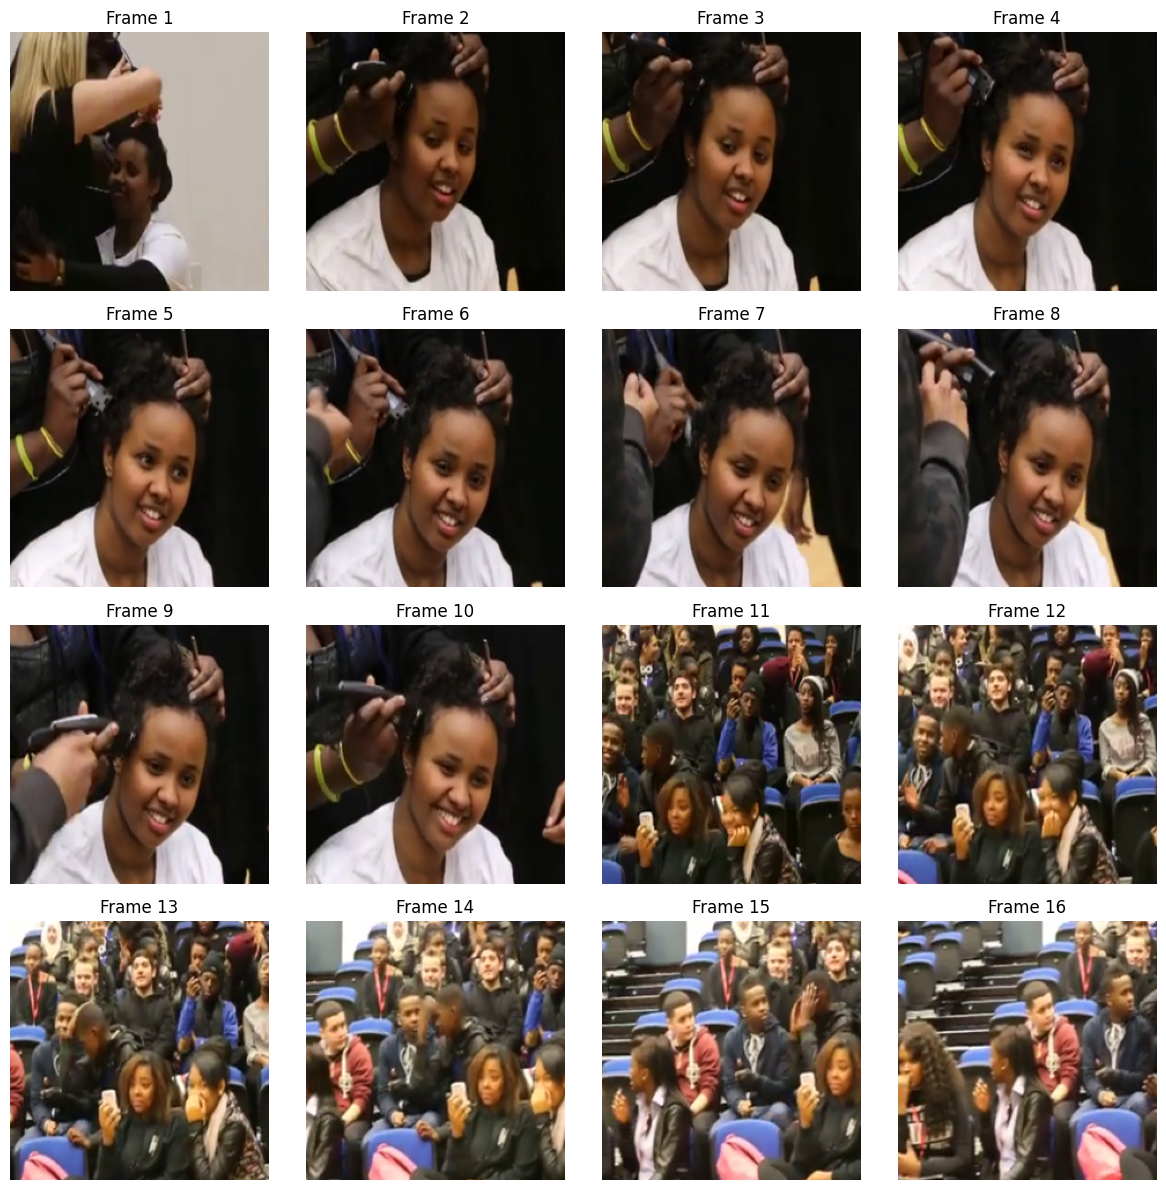

In [89]:
def show_frames(input_frames):
    """
    Displays the video frames from the input tensor.

    Args:
    - input_frames: torch.Tensor of shape [1, 3, 16, 112, 112] (video frames)
    """
    # Move tensor to CPU and convert to numpy
    frames = input_frames.squeeze(0).permute(1, 2, 3, 0).cpu().numpy()  # Shape: [16, 112, 112, 3]

    # Normalize frames to [0, 1] if they are in range [0, 255]
    if frames.max() > 1:
        frames = frames / 255.0

    # Create a figure
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()  # Ensure correct subplot indexing

    for i in range(16):
        frame = frames[i]  # Shape: [112, 112, 3]
        
        # Display result
        #frame = frame[..., ::-1]
        axes[i].imshow(frame)
        axes[i].set_title(f"Frame {i+1}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
show_frames(inputs) 

In [90]:
model = model.to(device)
output = model(inputs)

In [91]:
get_pred(output[0])

shaving head
